# CS5785 Homework 4

## 2. Random Forests for Image Approximation

[Yufan Zhang](https://yufanbruce.com/) (yz2894)

[Tian Jin](https://koapushjin.cargo.site/) (tj299)


In [64]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Ignore any warnings
import warnings

warnings.filterwarnings("ignore")

In [9]:
# PATH variables
DATA_PATH = "./data/"
IMG_PATH = "./img/"
RESULT_PATH = "./result/"

if not os.path.exists(IMG_PATH):
    os.makedirs(IMG_PATH)

if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

**Random Forests for Image Approximation** 

In this question, you will use random forest regression to approximate an image by learning a function, $f : R_2 → R$, that takes image (x, y) coordinates as input and outputs pixel brightness. This way, the function learns to approximate areas of the
image that it has not seen before.

1. Start with an image of the Mona Lisa. If you don’t like the Mona Lisa, pick another interesting image of your choice.

2. Preprocessing the input. To build your “training set,” uniformly sample 5,000 random (x, y) coordinate locations.

     - What other preprocessing steps are necessary for random forests inputs? Describe them, implement them, and justify your decisions. In particular, do you need to perform mean subtraction, standardization, or unit-normalization?

3. Preprocessing the output. Sample pixel values at each of the given coordinate locations. Each pixel contains red, green, and blue intensity values, so decide how you want to handle this. There are several options available to you:

     - Convert the image to grayscale
     - Regress all three values at once, so your function maps (x, y) coordinates to (r, g, b) values: $f : R_2 → R_3$
     - Learn a different function for each channel, $f_{Red} : R^2 → R$, and likewise for $f_{Green}$, $f_{Blue}$.

    Note that you may need to rescale the pixel intensities to lie between 0.0 and 1.0. (The default for pixel values may be between 0 and 255, but your image library may have different defaults.)
    
    What other preprocessing steps are necessary for random regression forest outputs? Describe them, implement them, and justify your decisions.

4. To build the final image, for each pixel of the output, feed the pixel coordinate through the random forest and color the resulting pixel with the output prediction. You can then use `imshow` to view the result. (If you are using grayscale, try `imshow(Y, cmap=‘gray’)` to avoid fake-coloring). You may use any implementation of random forests, but you should understand the implementation and you must cite your sources.

5. Experimentation.
   1. Repeat the experiment for a random forest containing a single decision tree, but with depths 1, 2, 3, 5, 10, and 15. How does depth impact the result? Describe in detail why.
   2. Repeat the experiment for a random forest of depth 7, but with number of trees equal to 1, 3, 5, 10, and 100. How does the number of trees impact the result? Describe in detail why.
   3. As a simple baseline, repeat the experiment using a k-NN regressor, for $k = 1$. This means that every pixel in the output will equal the nearest pixel from the “training set.” Compare and contrast the outlook: why does this look the way it does? You may use an existing implementation of k-NN but make sure to cite your source.
   4. Experiment with different pruning strategies of your choice.

6. Analysis
   1. What is the decision rule at each split point? Write down the 1-line formula for the split point at the root node for one of the trained decision trees inside the forest. Feel free to define any variables you need.
   2. Why does the resulting image look like the way it does? What shape are the patches of color, and how are they arranged?


### a. Load the Mona Lisa image

Shape of the image: (900, 604, 3)


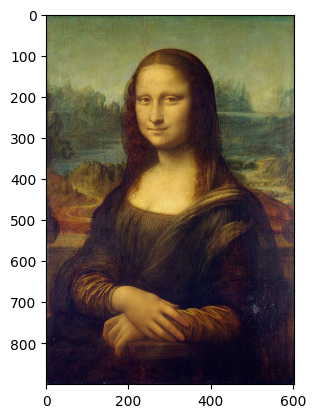

In [29]:
# Load the Mona Lisa image
mona_lisa = Image.open(IMG_PATH + "mona_lisa.jpg")
plt.imshow(mona_lisa)

mona_lisa = np.array(mona_lisa)
height, width, _ = mona_lisa.shape
all_coords = np.array([[x, y] for y in range(height) for x in range(width)])
print(f"Shape of the image: {mona_lisa.shape}")

### b. Preprocessing the input

In [18]:
# Generate 5,000 random coordinates
num_samples = 5000
x_coords = np.random.randint(0, width, num_samples)
y_coords = np.random.randint(0, height, num_samples)

# Combine x and y coordinates
coords = np.column_stack((x_coords, y_coords))

print(f"Shape of the coordinates: {coords.shape}")

Shape of the coordinates: (5000, 2)


### c. Preprocessing the output

Regress all three values at once, so your function maps (x, y) coordinates to (r, g, b) values: $f : R_2 → R_3$

In [23]:
# Extract pixel values (RGB) at these coordinates
pixel_values = mona_lisa[y_coords, x_coords]

# Normalize pixel values to be between 0 and 1
pixel_values_normalized = pixel_values / 255.0

# Splitting normalized pixel values into training and testing sets
# Use the same split as before for consistency
pixel_values_train_normalized, pixel_values_test_normalized = train_test_split(pixel_values_normalized, test_size=0.2)

print(f"Shape of training set with labels:\t{pixel_values_train_normalized.shape}")
print(f"Shape of testing set with labels:\t{pixel_values_test_normalized.shape}")

Shape of training set with labels:	(4000, 3)
Shape of testing set with labels:	(1000, 3)


### d. Build the final image

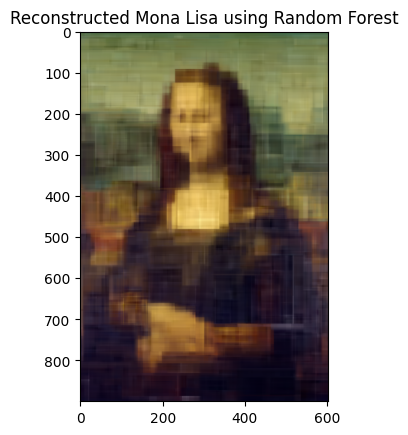

In [46]:
# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees in the forest
model.fit(coords, pixel_values_normalized)

# Predicting RGB values for each pixel in the image
predicted_pixel_values = model.predict(all_coords)

# Reshape the predicted values to the shape of the image
predicted_image = predicted_pixel_values.reshape(height, width, 3)

# Visualize the reconstructed image
plt.imshow(predicted_image)
plt.title("Reconstructed Mona Lisa using Random Forest")
plt.savefig(RESULT_PATH + "reconstructed_mona_lisa_random_forest.png")
plt.show()

### e. Experimentation

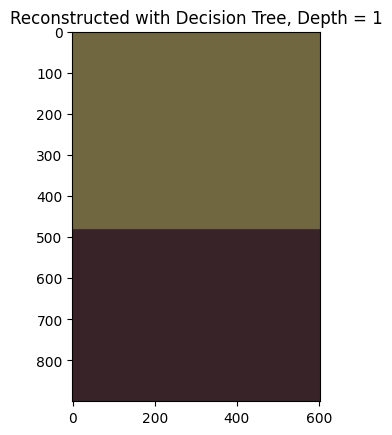

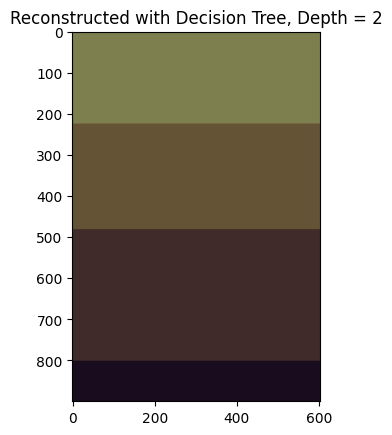

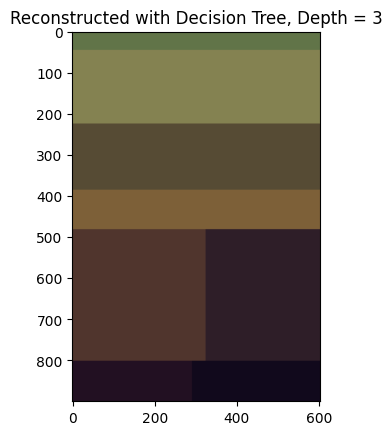

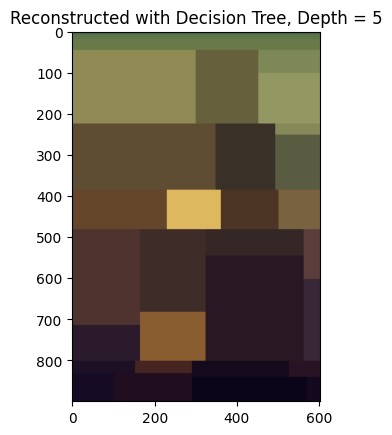

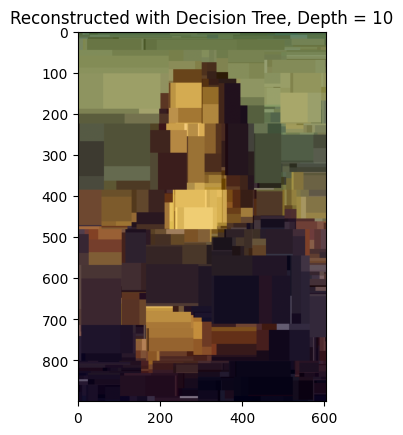

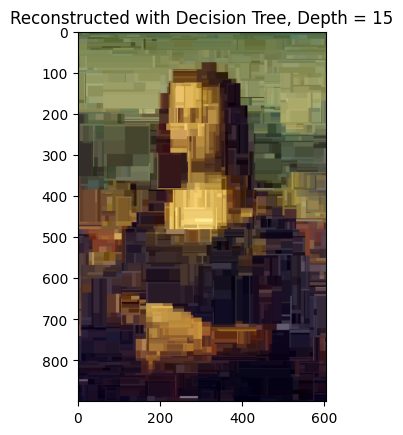

In [38]:
# 1. Single Decision Tree at Various Depths
def predict_with_decision_tree(depth):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    plt.title(f"Reconstructed with Decision Tree, Depth = {depth}")
    plt.savefig(RESULT_PATH + f"reconstructed_mona_lisa_decision_tree_depth_{depth}.png")
    plt.show()

# Experiment with different depths
for depth in [1, 2, 3, 5, 10, 15]:
    predict_with_decision_tree(depth)


The resulting images of this experiment clearly demonstrate how the depth of a decision tree impacts the result in terms of image approximation. Here's a detailed description of this effect:

- **Depth = 1:**
  - The tree makes only one split, which results in the entire image being divided into two regions based on the pixel values that most reduce the variance in those regions.
  - This leads to an extremely abstracted version of the Mona Lisa, essentially dividing the image into two large, homogenous blocks of color.

- **Depth = 2:**
  - The tree is allowed to make one additional split on each of the two regions created by the first split.
  - This results in four regions of uniform color. The approximation is still very abstract, but begins to hint at variance in color across the image.

- **Depth = 3:**
  - Now the tree can make two additional splits, leading to eight regions.
  - The additional splits allow for more granularity, and we can start to see a very rough outline of the image features, like the division between the background and the figure.

- **Depth = 5:**
  - The tree grows more complex, with more splits allowing for 32 regions.
  - The increased depth allows the tree to capture more detail, as evidenced by the more defined areas of color that start to resemble the layout of the Mona Lisa.

- **Depth = 10:**
  - The complexity of the tree increases significantly, with the ability to make 1024 distinct regions if fully grown.
  - The increased depth allows for finer distinctions between the colors and starts to show recognizable features of the Mona Lisa, such as the face and the upper body, although the image is still blocky.

- **Depth = 15:**
  - The decision tree is now highly complex, potentially creating thousands of regions.
  - This depth allows for even more detail, and the approximation begins to more closely resemble the original image. However, it may also start to overfit the training data, capturing noise and artifacts that aren't present in the original image.

As the depth increases, the decision tree can make more splits, allowing it to fit the training data more closely. However, this does not necessarily mean that the model is capturing the true structure of the data; beyond a certain point, increasing depth can lead to overfitting, where the model is too tailored to the training data and may not generalize well. In the context of image approximation, a deeper tree may capture more detail, but it may also introduce noise and fail to produce a smooth approximation of the image. The sweet spot for depth would depend on the complexity of the image and the number of samples; too little depth and the image is overly abstracted, too much depth and the image may become noisy.

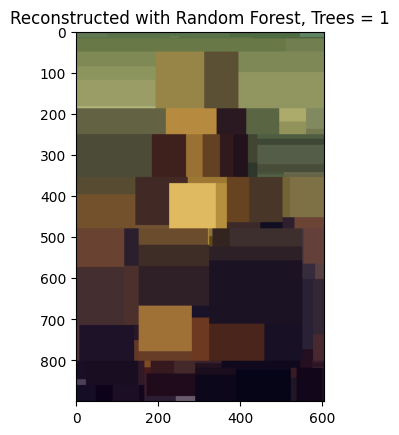

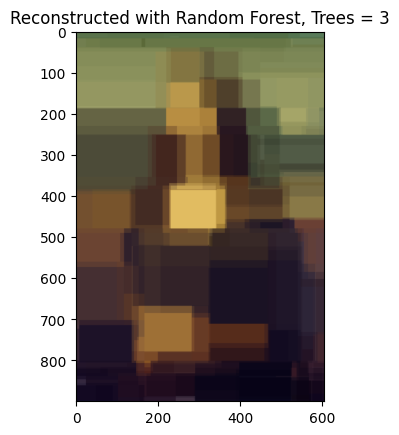

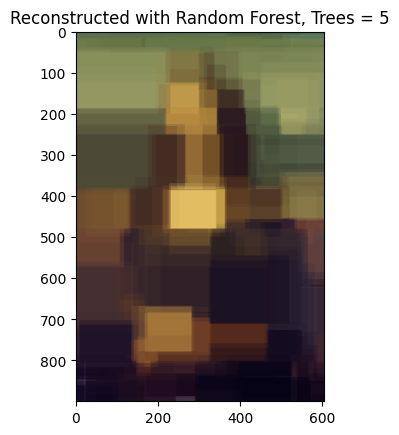

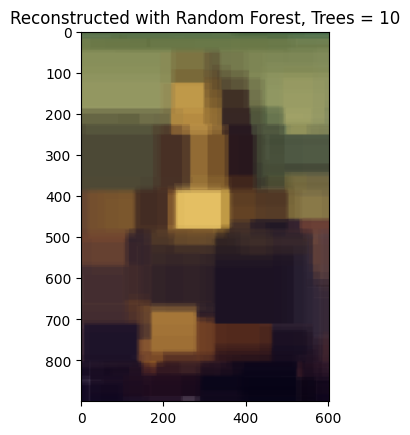

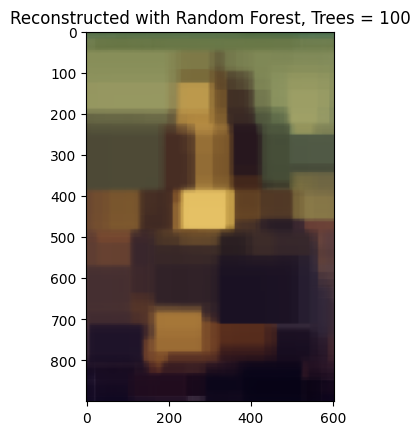

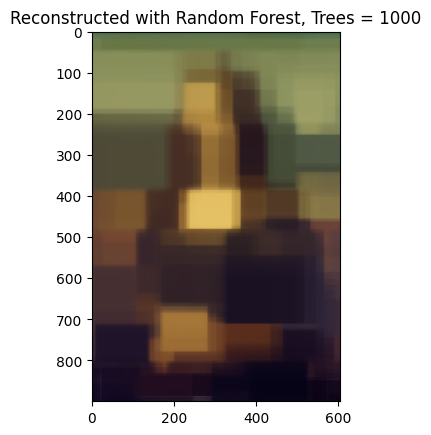

In [44]:
# 2. Random Forest with Varying Number of Trees
# Function to create and train a random forest, then predict the whole image
def predict_with_random_forest(n_trees):
    model = RandomForestRegressor(n_estimators=n_trees, max_depth=7, random_state=42)
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    plt.title(f"Reconstructed with Random Forest, Trees = {n_trees}")
    plt.savefig(RESULT_PATH + f"reconstructed_mona_lisa_random_forest_trees_{n_trees}.png")
    plt.show()

# Experiment with different numbers of trees
for n_trees in [1, 3, 5, 10, 100, 1000]:
    predict_with_random_forest(n_trees)


The effect of the number of trees in a Random Forest with a fixed maximum depth of 7 can be described as follows:

- **Trees = 1:**
  - A single tree generates blocky regions of homogeneous colors. The image appears very abstract with large blocks, because there is no aggregation of predictions to smooth out the variability.

- **Trees = 3:**
  - With three trees, the boundaries between color blocks become less distinct, indicating the beginning of variance reduction through averaging the output of multiple trees. The blockiness persists, but you can start to see some blurring at the edges.

- **Trees = 5:**
  - With five trees, the trend continues. The blurring at the boundaries of color blocks becomes more pronounced. This blurring effect is due to the averaging of different decision boundaries from the ensemble of trees, which starts to fill in gaps and smooth out sharp transitions.

- **Trees = 10:**
  - At ten trees, the image does not appear to have drastically improved in detail compared to the image with five trees. The blocks are still present, but the boundaries are increasingly blurred, which makes the transitions between different color regions smoother.

- **Trees = 100:**
  - With one hundred trees, the blockiness remains but is accompanied by a considerable increase in boundary blurring, creating a more blended effect in the image. However, the overall structure and detail do not significantly change from the forest with ten trees. This suggests that increasing the number of trees beyond a certain point (in this case, around ten) does not substantially improve the perceptual quality of the reconstruction with a fixed depth.

The blurring of the boundaries as more trees are added is due to the ensemble's ability to better capture the variability of the data. Each tree contributes its own "vote" on the color of a pixel, and as more votes are collected, the final color becomes the average of more diverse opinions, leading to a smoother transition between different color blocks.

The lack of significant change beyond ten trees could indicate that the ensemble has reached a point where additional trees do not provide new information or a significantly different "vote" on the pixel colors, and thus the visual quality of the approximation stabilizes. This plateau effect is common in ensemble learning; past a certain number of trees, additional improvements become marginal and may not justify the additional computation cost.

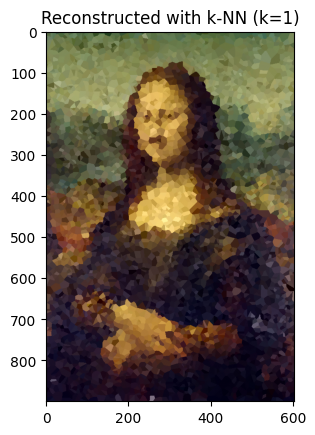

In [40]:
# 3. k-NN Regressor Experiment
# Train and predict with k-NN
knn_model = KNeighborsRegressor(n_neighbors=1)
knn_model.fit(coords, pixel_values_normalized)
predicted_pixel_values_knn = knn_model.predict(all_coords).reshape(height, width, 3)

# Visualize the result
plt.imshow(predicted_pixel_values_knn)
plt.title("Reconstructed with k-NN (k=1)")
plt.savefig(RESULT_PATH + "reconstructed_mona_lisa_knn.png")
plt.show()

The reconstructed images using Random Forest and k-NN (k=1) reveal distinct characteristics due to the inherent differences in how these algorithms make predictions:

**Random Forest Reconstruction:**
- The image reconstructed with Random Forest exhibits a smoother appearance with more blended transitions between colors.
- The algorithm creates an ensemble of decision trees, each contributing a vote towards the final prediction. This ensemble approach effectively averages the results of many different models, which tends to smooth out the noise and variance.
- Random Forest benefits from both bagging (bootstrapping aggregates) and feature randomness when building each tree, which generally results in a more generalized model and avoids overfitting to the training data.
- The smoothing effect is also due to the model's averaging process across many trees, which can capture a broader range of color variability and lead to a more continuous and cohesive color gradient.

**k-NN Reconstruction:**
- The k-NN image appears more patchy and less smooth. This patchiness is because the k-NN algorithm assigns the value of the nearest neighbor to each prediction point without any averaging, leading to a mosaic of different colors.
- With k=1, the prediction for a given pixel is exactly the color of the closest sample point, which can create a 'stippled' effect as each pixel takes on the color of the nearest sampled pixel in the input space.
- k-NN does not inherently account for the overall distribution of colors and can be influenced by local discrepancies in the sampled points, leading to abrupt changes in color between neighboring pixels.
- This method is highly sensitive to the local structure of the training data and lacks the generalizing effect of averaging multiple predictions, which can result in more apparent noise or artifacts in the reconstructed image.

**Comparison:**
- The Random Forest reconstruction is smoother and may more closely resemble a blurred painting, while the k-NN reconstruction is more akin to pointillism, with distinct regions of solid color.
- The k-NN method's visual sharpness in some areas is due to the exact matching of the nearest neighbor's value, while Random Forest's blurriness is a result of averaging over many decision trees.
- The granularity and sharpness in the k-NN image result from its reliance on the local similarity, which can be good for capturing fine details if the sample density is high enough, but Random Forest's blending effect is better for creating a coherent overall image when the sampling is sparse.

The differences between the images are a direct result of the contrasting methodologies: Random Forest's ensemble averaging creates smoothness, while k-NN's reliance on nearest neighbors results in a patchwork of local approximations.

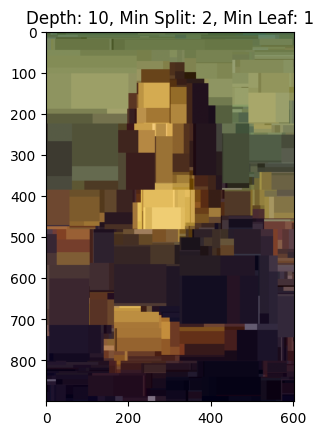

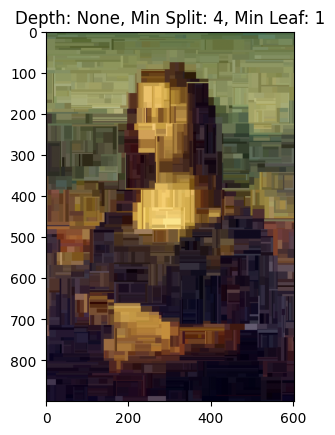

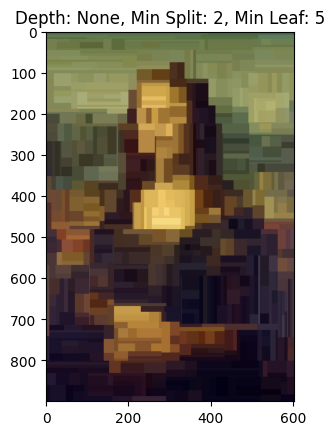

In [41]:
# 4. Decision Tree with Different Pruning Strategies
def experiment_pruning(max_depth=None, min_samples_split=2, min_samples_leaf=1):
    model = DecisionTreeRegressor(max_depth=max_depth, 
                                  min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf)
    model.fit(coords, pixel_values_normalized)
    predicted_pixel_values = model.predict(all_coords).reshape(height, width, 3)
    plt.imshow(predicted_pixel_values)
    title = f"Depth: {max_depth}, Min Split: {min_samples_split}, Min Leaf: {min_samples_leaf}"
    plt.title(title)
    plt.savefig(RESULT_PATH + f"reconstructed_mona_lisa_decision_tree_pruning_{title}.png")
    plt.show()

# Experiment with different pruning parameters
experiment_pruning(max_depth=10)  # Limiting depth
experiment_pruning(min_samples_split=4)  # Increasing minimum samples for split
experiment_pruning(min_samples_leaf=5)  # Increasing minimum samples in leaf


The provided images from the experiment with different pruning strategies illustrate how varying the decision tree's hyperparameters can affect the model's predictions and the resultant image approximation.

**Image with Depth 10, Min Split 2, Min Leaf 1:**
- This configuration limits the tree depth to 10, which restricts the model from creating an excessively fine-grained partition of the feature space. The maximum number of splits is capped, leading to less overfitting and smoother transitions between color blocks.
- However, because the minimum number of samples per leaf is set to 1, the tree is still allowed to create very specific rules for certain areas, which can lead to some overfitting, as evidenced by the presence of some distinctly sharp color blocks.

**Image with Depth None, Min Split 2, Min Leaf 5:**
- Without a maximum depth (`None`), the tree is allowed to grow until all leaves are pure or until there are less than `min_samples_split` samples to split a node. In this case, the tree grows more complex, potentially capturing more detail but also risking overfitting.
- Setting `min_samples_leaf` to 5 means that each leaf has a minimum number of samples, which encourages smoother and more generalized regions. This is reflected in the image, where the color blocks appear more blended, and less 'patchy' than in the previous image.

**Image with Depth None, Min Split 4, Min Leaf 1:**
- This tree also has no maximum depth, allowing for very complex trees. The increase in `min_samples_split` to 4 means that a split will be considered only if there are at least four samples to split, which can reduce the variance in the model's predictions but might still create very specific and complex rules in the regions where the data is dense.
- With `min_samples_leaf` set to 1, the leaves can be very specific, similar to the first image. However, due to the higher `min_samples_split`, the model is less prone to creating as many fine-grained splits, leading to slightly smoother transitions between colors compared to the first image but still retaining a fair amount of detail.

**Impact of Pruning Strategies:**
- **Maximum Depth (max_depth):** A lower maximum depth generally results in a simpler model with larger, more homogenous blocks of color, as the tree cannot make as many decisions based on the input data. A higher maximum depth or no limit allows the tree to make more complex decisions, capturing more detail but also increasing the risk of overfitting.
- **Minimum Samples for Split (min_samples_split):** Increasing this value leads to fewer splits because the algorithm requires more data to justify making a split. This results in a more generalized model with fewer, larger blocks of color.
- **Minimum Samples in Leaf (min_samples_leaf):** Setting a higher minimum for samples in a leaf produces a more generalized model with smoother color transitions, as each decision in the tree has to apply to at least that many samples.

Each of these pruning strategies controls the balance between the complexity of the model (and thus its ability to capture fine details) and the model's generality (its ability to produce smooth transitions and avoid overfitting). The goal is to find a balance that captures the essential features of the Mona Lisa without introducing too much noise or losing too much detail.

### f. Analysis

In [54]:
# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(coords, pixel_values_normalized)

# Extract one of the trees from the forest
single_tree = rf.estimators_[0]  # Grabbing the first decision tree

# Get the decision rule for the root node
feature = single_tree.tree_.feature[0]  # Feature used for the split
threshold = single_tree.tree_.threshold[0]  # Threshold value for the split

# Define the variables
# x[feature] is the feature value of the input data point
# 'threshold' is the threshold value for the root node

decision_rule = f"if x[{feature}] < {threshold}: go to left child node, else: go to right child node"

print(decision_rule)

if x[1] < 479.5: go to left child node, else: go to right child node


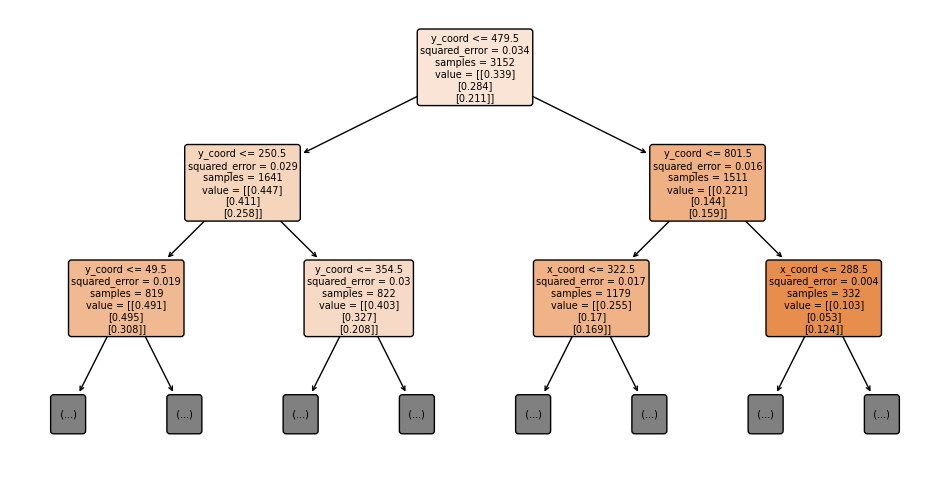

In [63]:
from sklearn import tree

# Visualize the first 5 levels of the tree
plt.figure(figsize=(12, 6))
tree.plot_tree(
    single_tree, 
    max_depth=2, 
    filled=True, 
    feature_names=['x_coord', 'y_coord'],
    rounded=True
)
plt.savefig(RESULT_PATH + "decision_tree.png")
plt.show()

1. **Decision Rule at Each Split Point:**
   The decision rule at each split point in a decision tree is typically a binary condition on one of the features. For the root node, the decision rule can be represented as:
   ```python
   if x[feature] < threshold:
       # Go to the left subtree
   else:
       # Go to the right subtree
   ```
   Here `x[feature]` represents the value of the selected feature for splitting, and `threshold` is the value that determines the split. The selected feature in the context of image approximation would be one of the two coordinates (x or y), and the threshold would be a value within the range of that coordinate.

2. **Resulting Image Appearance:**
   - The resulting image looks the way it does primarily due to the hierarchical, binary partitioning nature of decision trees. Each split divides the input space into two regions based on whether the input feature value is less than or greater than the split threshold.
   - The shape of the patches of color is generally rectangular or blocky. This is because each decision in the tree splits the space along the axis of one of the features, which corresponds to either the x or y coordinate in the image space. As a result, the decision boundaries are aligned with the coordinate axes, creating rectangular partitions.
   - These patches are arranged in a manner that reflects the hierarchical decision-making process of the tree. At each node in the tree, a split is made that creates two child nodes, each representing a rectangular region of the image. The arrangement of these patches corresponds to the sequence of decisions made from the root of the tree down to its leaves, where each leaf node corresponds to a final color prediction for the region it represents.